In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture
from lightgbm import LGBMClassifier
import optuna
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
base_path = 'E:/python/data/训练赛/TabularPlaygroundSeriesMar/'
test = pd.read_csv(base_path + 'test.csv', index_col='id')
train = pd.read_csv(base_path + 'train.csv', index_col='id')
target = train['target']
data = pd.concat((train[[f for f in train.columns.tolist() if f not in ['id', 'target']]], test))

In [4]:
categroies = [f for f in train.columns.tolist() if f.startswith('cat')]
continues = [f for f in train.columns.tolist() if f.startswith('cont')]

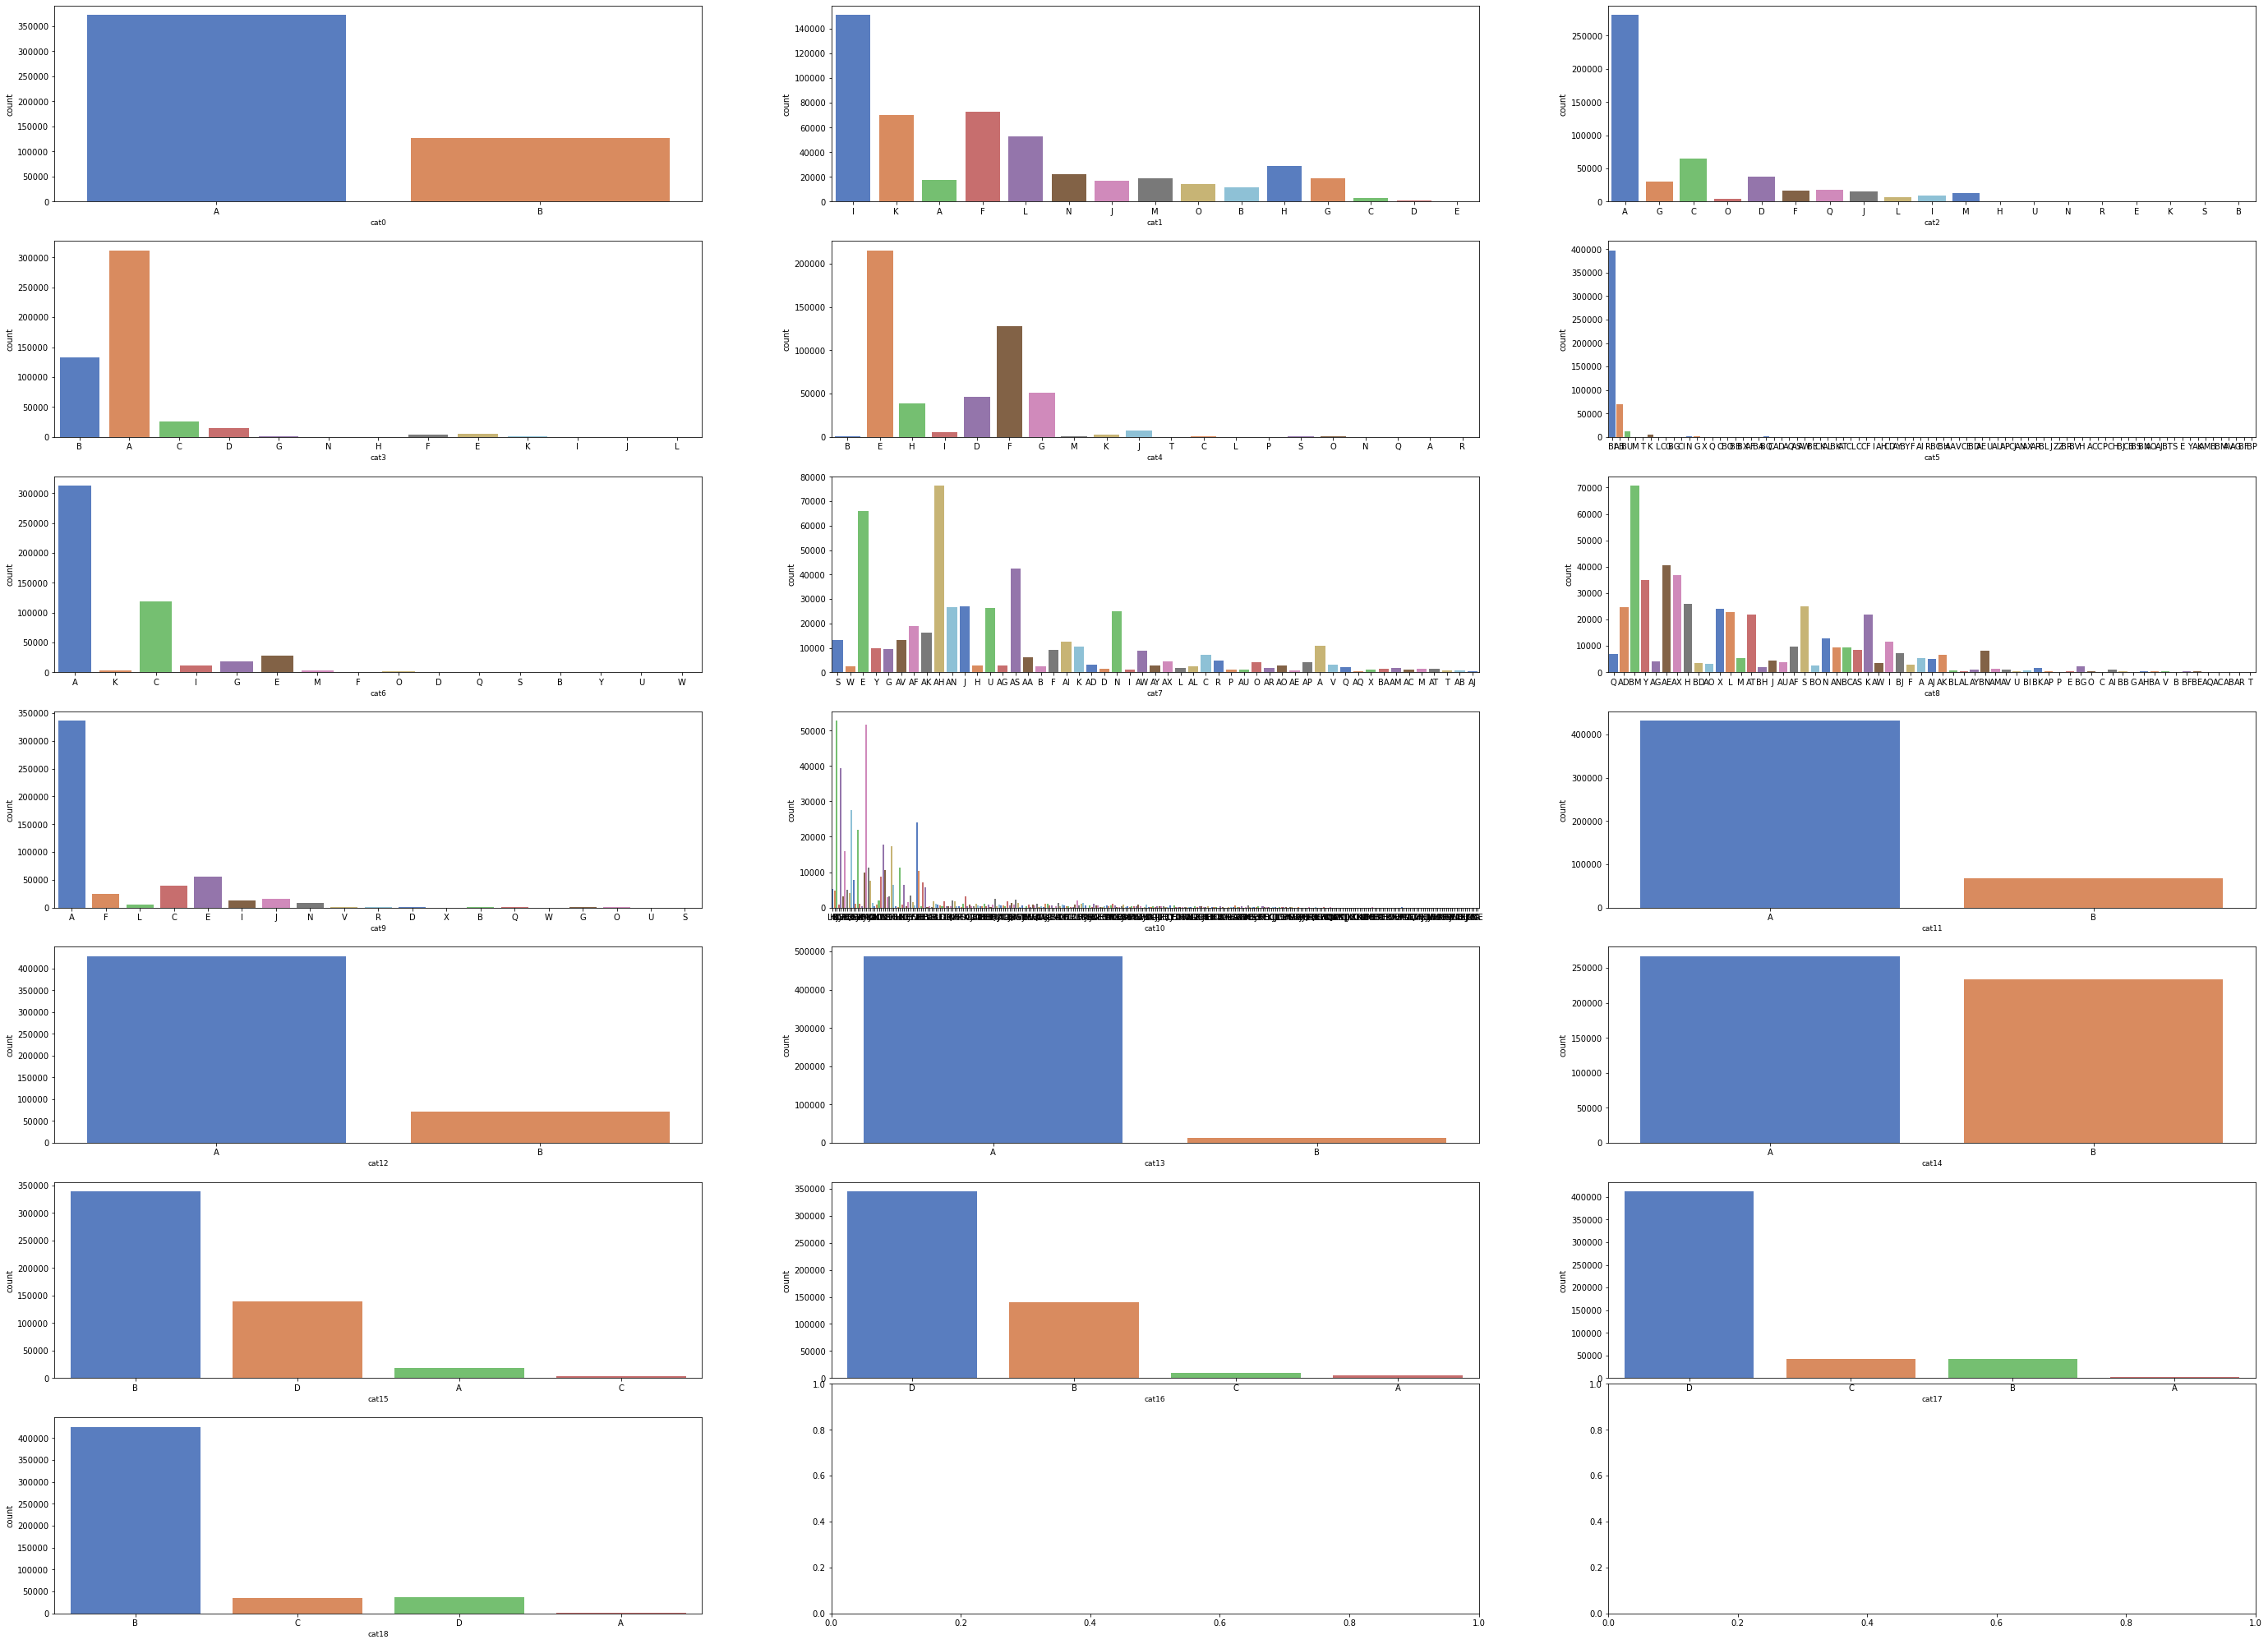

In [12]:
plt.subplots(6,3,figsize = (48,36))
plt.subplots_adjust(wspace =0.2, hspace =0.2)
for i,feature in enumerate(categroies):
    plt.subplot(7,3,i+1)
    sns.countplot(x=feature, data = data, palette='muted')
    plt.xlabel(feature,fontsize=9)
plt.show()

In [21]:
_data = data.copy()
for i,feature in enumerate(categroies):
    cat_count = data.groupby(feature)['cont1'].count()
    indexs = []
    for cate in cat_count.index.tolist():
        if cat_count[cate] <1000:
            indexs.append(cate)
    _data[feature][_data[feature].apply(lambda x:x in indexs)] = 'MT'
    cat_count = _data.groupby(feature)['cont1'].count()


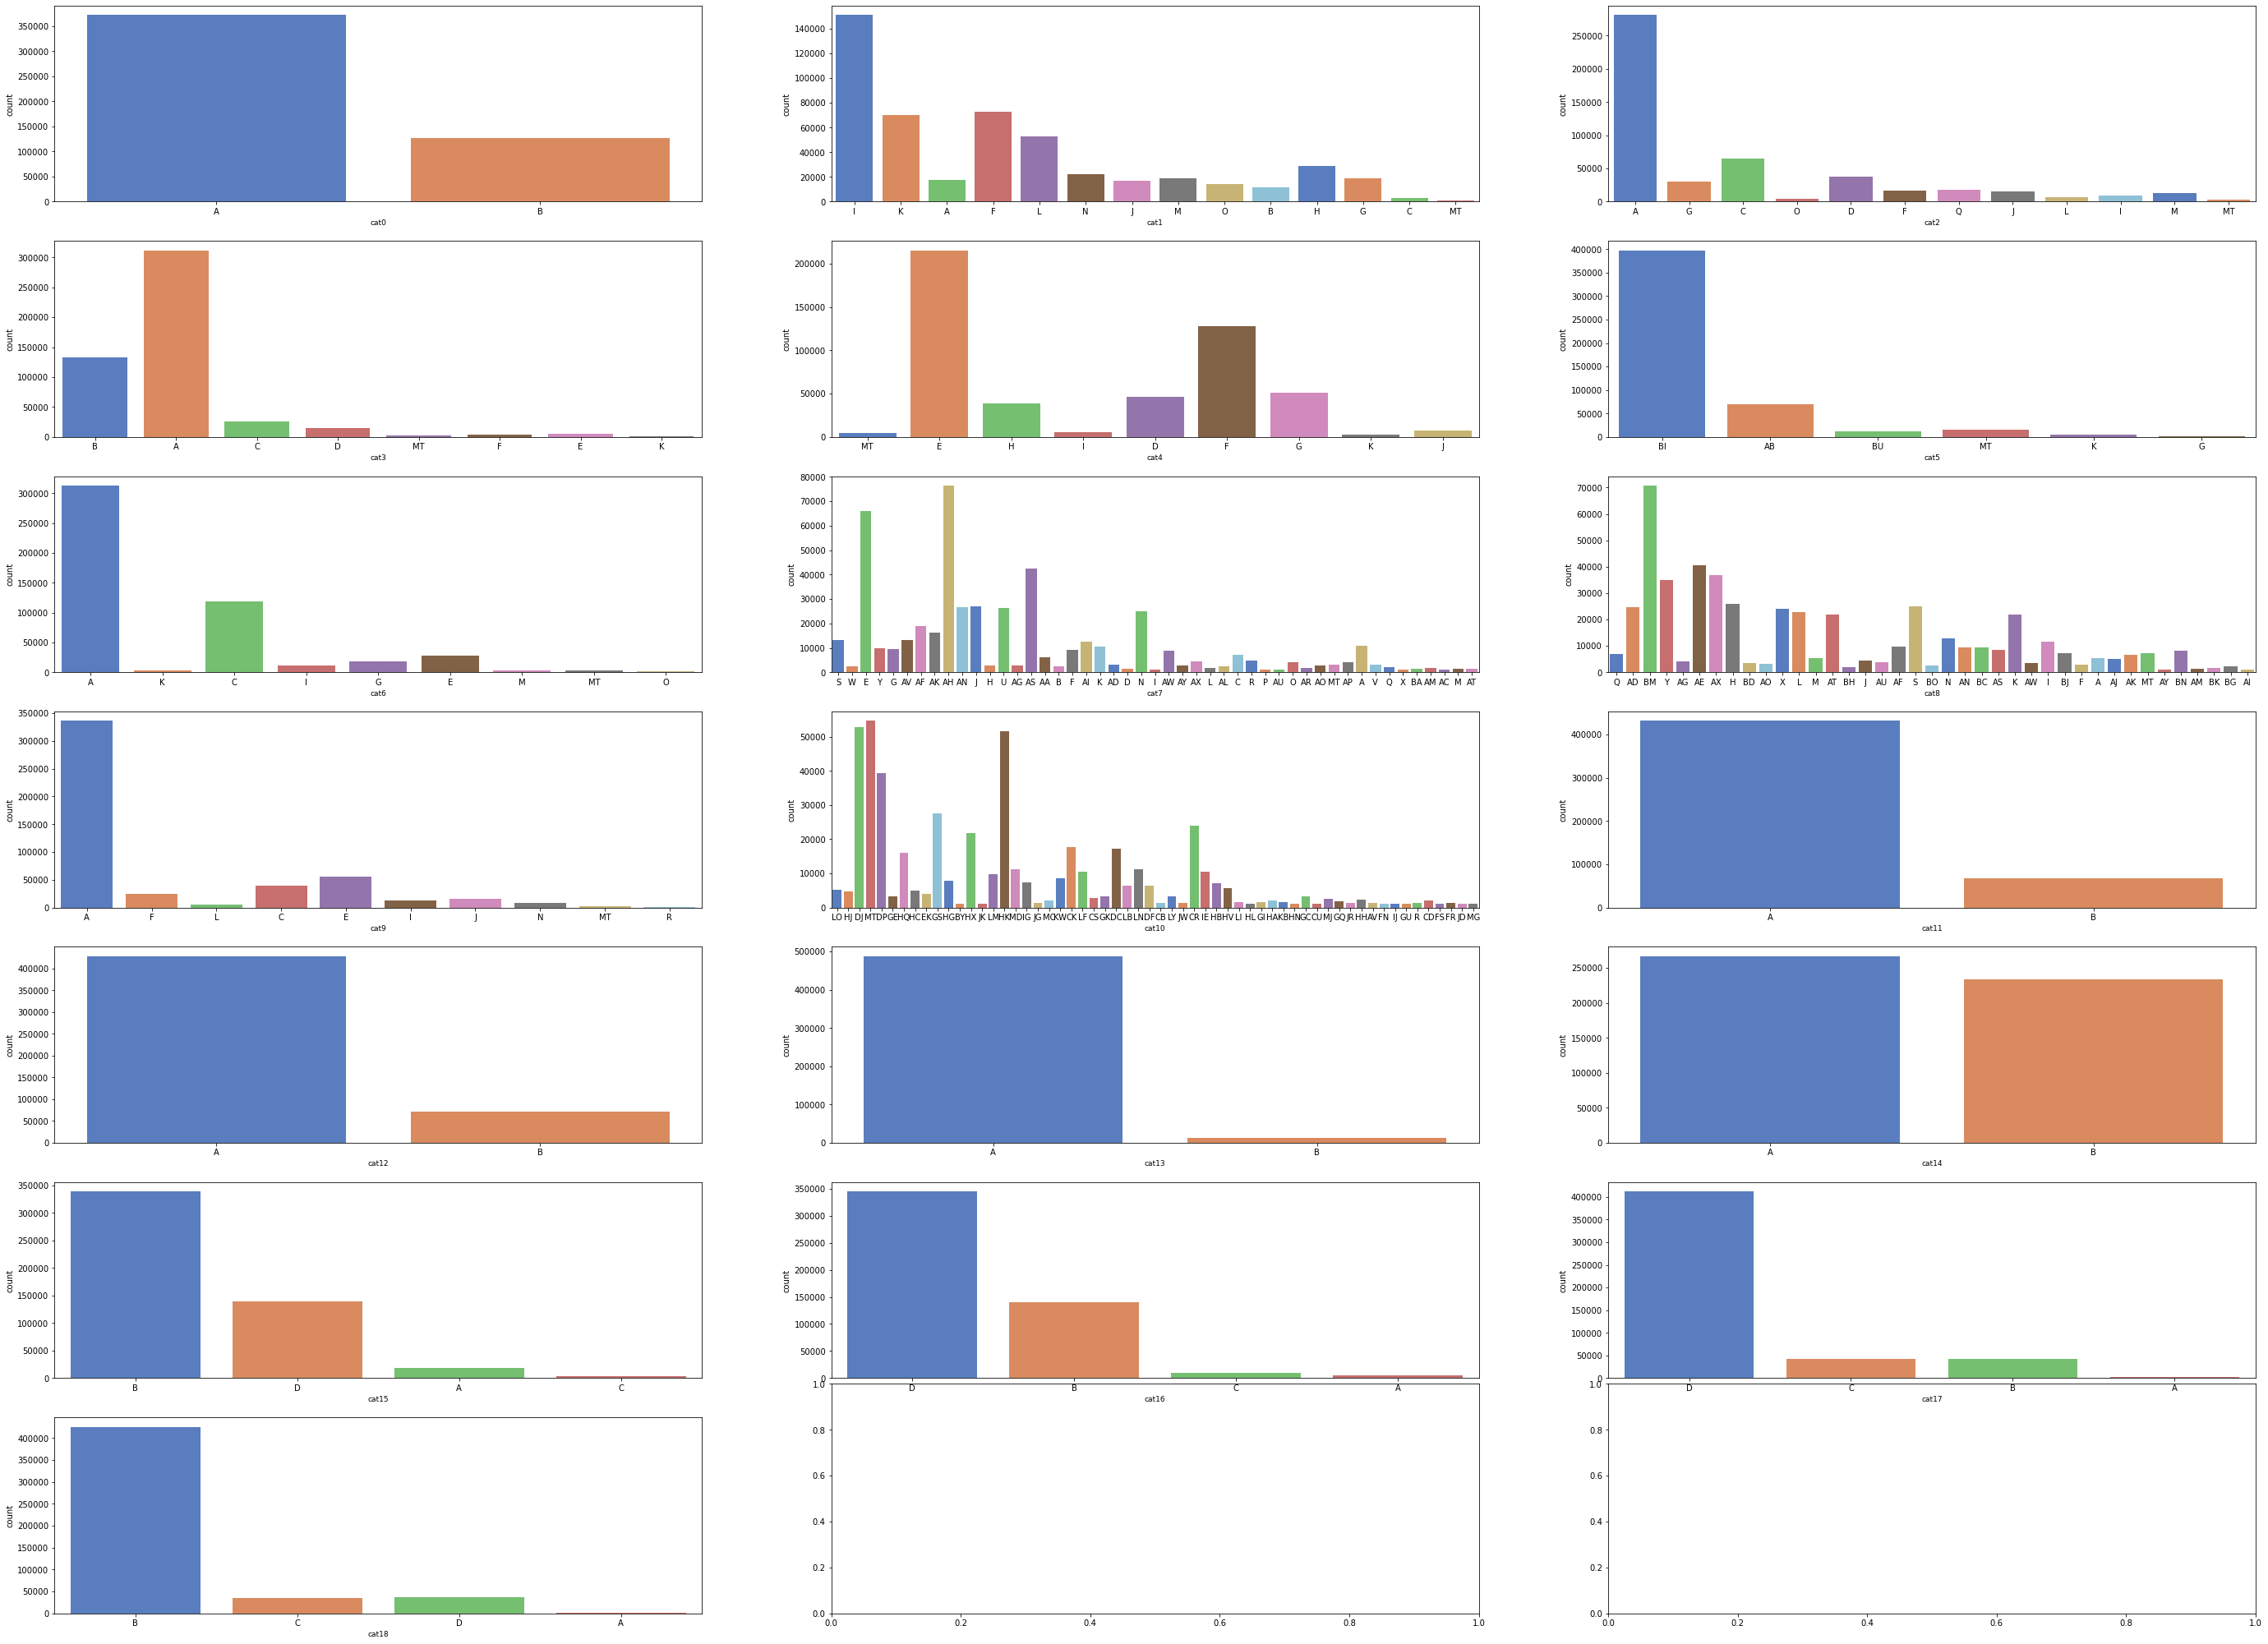

In [22]:
plt.subplots(6,3,figsize = (48,36))
plt.subplots_adjust(wspace =0.2, hspace =0.2)
for i,feature in enumerate(categroies):
    plt.subplot(7,3,i+1)
    sns.countplot(x=feature, data = _data, palette='muted')
    plt.xlabel(feature,fontsize=9)
plt.show()

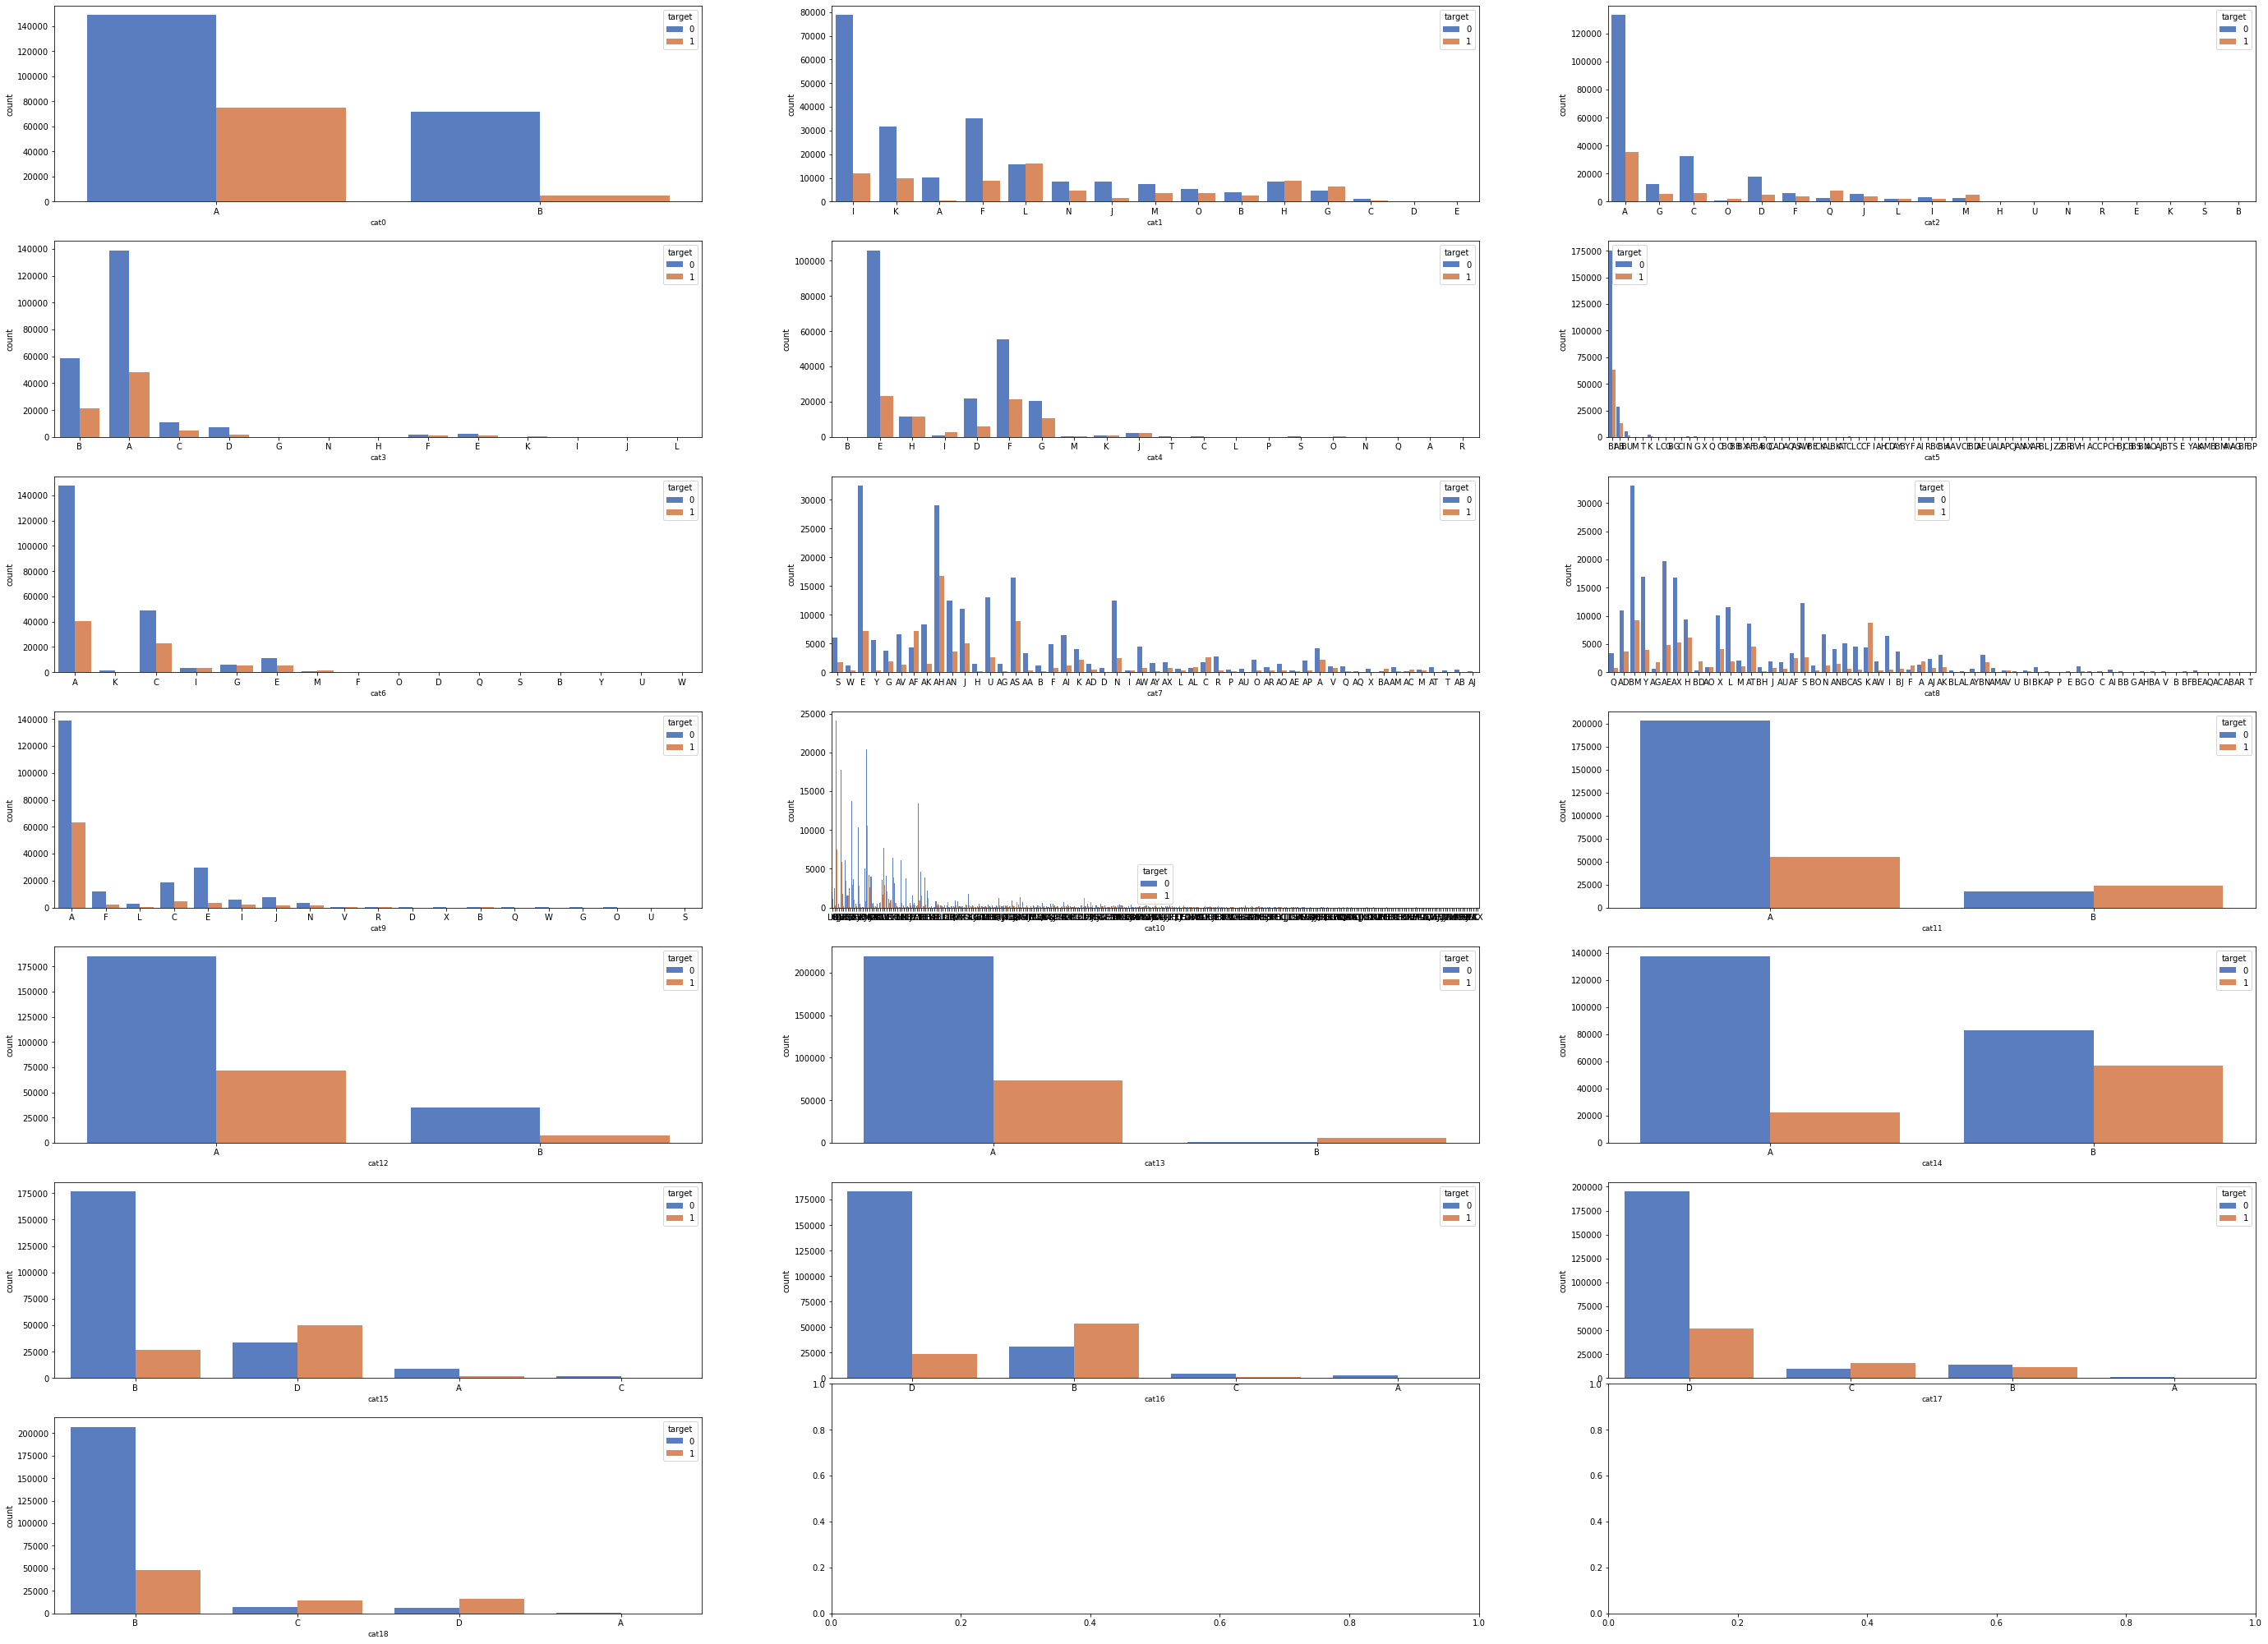

In [42]:
plt.subplots(6,3,figsize = (48,36))
plt.subplots_adjust(wspace =0.2, hspace =0.2)
for i,feature in enumerate(categroies):
    plt.subplot(7,3,i+1)
    sns.countplot(x=feature, data = train,hue='target', palette='muted')
    plt.xlabel(feature,fontsize=9)
plt.show()

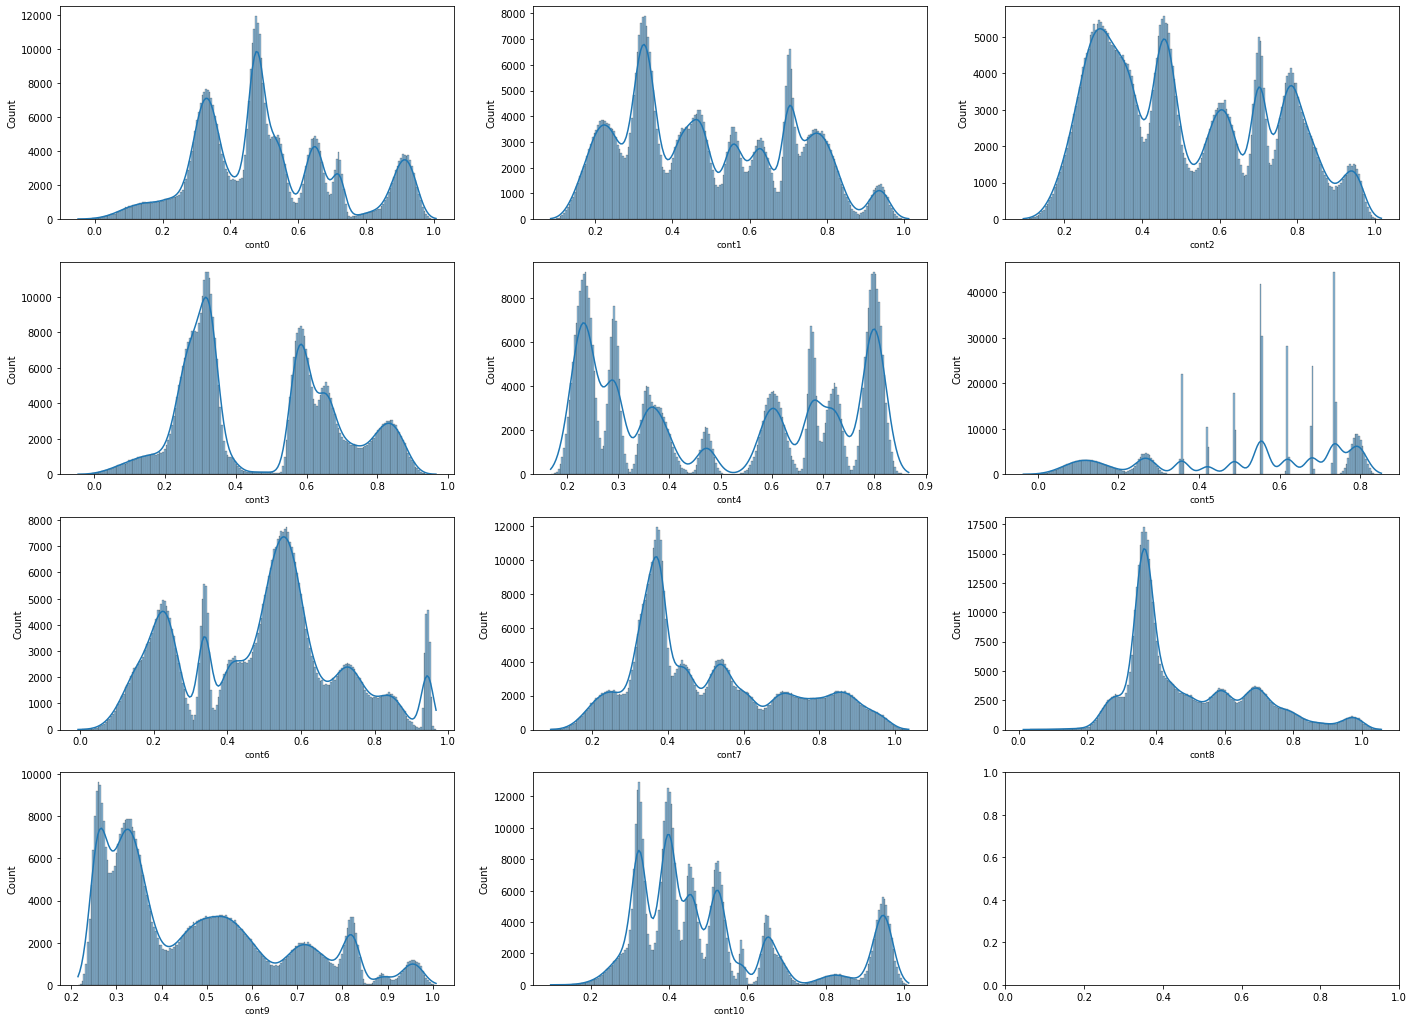

In [44]:
plt.subplots(4,3,figsize=(24,18))
for i,feature in enumerate(continues):
    plt.subplot(4,3,i+1)
    sns.histplot(x=feature,data=_data,kde=True,bins=200)
    plt.xlabel(feature,fontsize=9)
plt.show()

In [23]:
inits = [[0.3,0.48,0.65,0.72,0.91],
         [0.22,0.31,0.46,0.58,0.61,0.7,0.78,0.95],
         [0.3,0.45,0.6,0.7,0.79,0.95],
         [0.3,0.59,0.63,0.83],
         [0.23,0.29,0.35,0.47,0.6,0.68,0.72,0.8],
         [0.1,0.25,0.35,0.42,0.45,0.55,0.62,0.68,0.73,0.79],
         [0.22,0.35,0.41,0.55,0.72,0.82,0.95],
         [0.25,0.38,0.42,0.54,0.7,0.86],
         [0.29,0.38,0.59,0.7,0.98],
         [0.25,0.33,0.52,0.71,0.81,0.89,0.95],
         [0.3,0.4,0.45,0.54,0.59,0.63,0.82,0.92]
        ]
for feature,init in zip(continues, inits):
    x = np.array(_data[feature].tolist()).reshape(-1,1)
    mean_intit = np.array(init)[:,None]
    gmm = GaussianMixture(n_components=len(init),means_init=mean_intit, random_state=10).fit(x)
    pred = gmm.predict(x)
    _data[f'{feature}_gmm'] = pred

In [24]:
X = _data.loc[train.index]
X['target'] = target

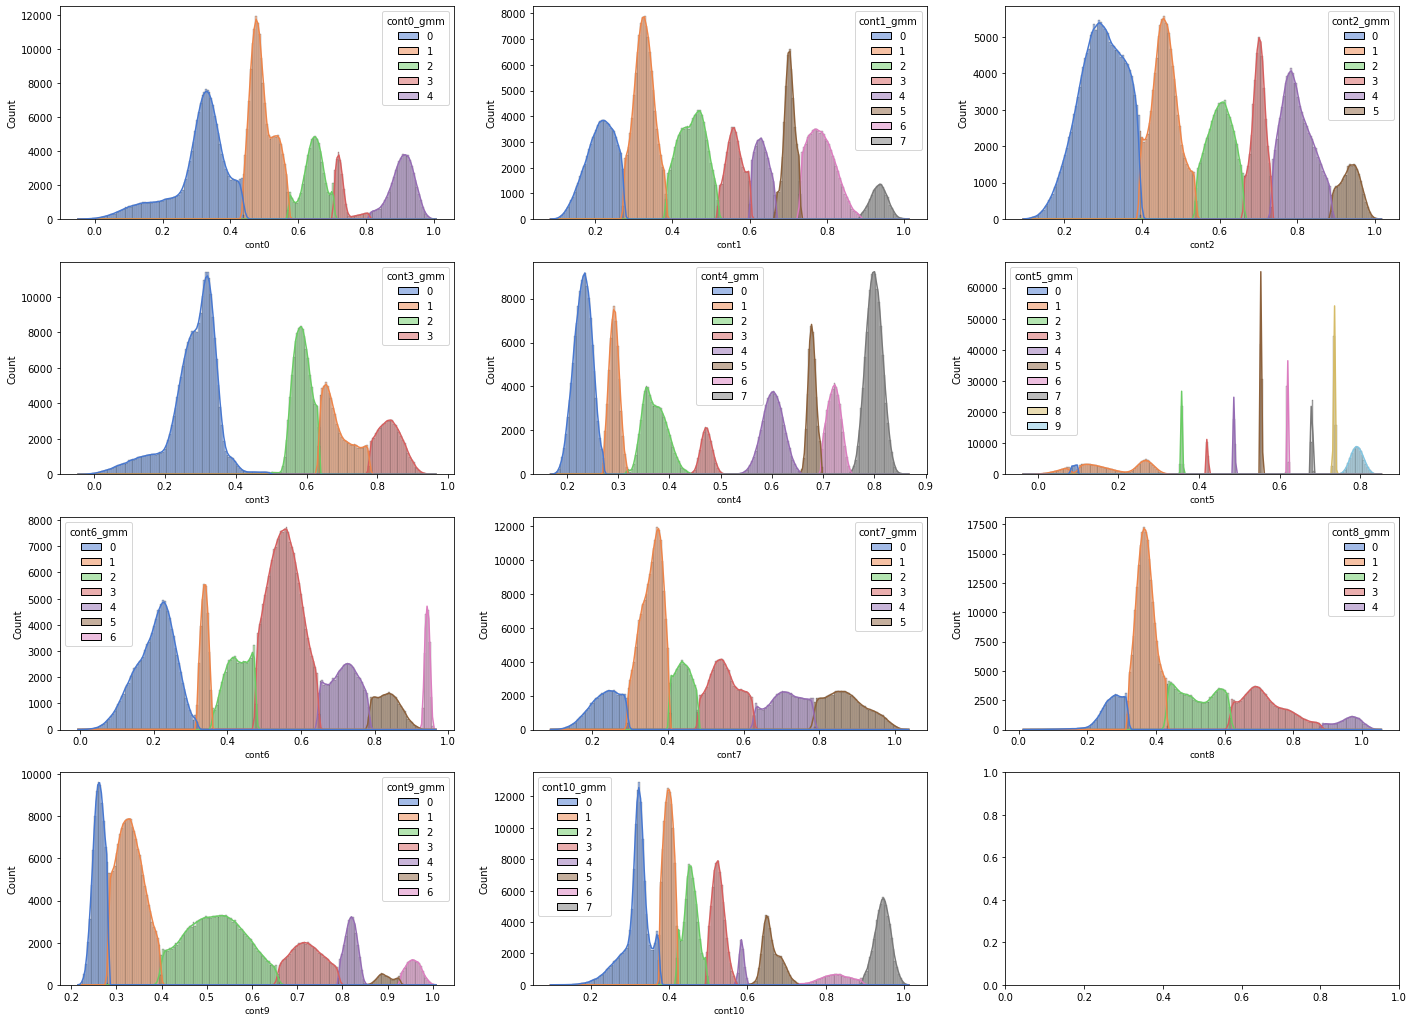

In [58]:
plt.subplots(4,3,figsize=(24,18))
for i,feature in enumerate(continues):
    plt.subplot(4,3,i+1)
    sns.histplot(x=feature,data=_data,bins=200,kde=True,hue=f'{feature}_gmm',palette='muted')
    plt.xlabel(feature,fontsize=9)
plt.show()

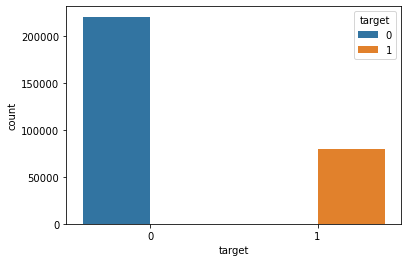

In [11]:
sns.countplot(x=target,data=X,hue='target')
plt.show()

In [25]:
threshold = target[target==1].count()/target.count()

In [26]:
for feature in categroies:
    lr = LabelEncoder()
    _data[feature] = lr.fit_transform(_data[feature])

cat0  cat1  cat2  cat3  cat4  cat5  cat6  cat7  cat8  cat9  ...  \
id                                                                  ...   
0          0     6     0     1     8     1     0    41    35     0  ...   
1          0     6     0     0     1     1     5    44     1     3  ...   
2          0     8     0     0     1     1     0    26    23     6  ...   
3          0     8     0     2     1     1     0    46     1     3  ...   
4          0     6     4     1     1     1     1    28    35     0  ...   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
499983     0    12     0     3     2     1     0     4    15     0  ...   
499984     1     6     0     1     1     1     0    15    36     2  ...   
499987     0     9     2     0     4     1     0    11    29     0  ...   
499994     0     8     0     2     2     1     0    40    23     0  ...   
499998     0     8     0     0     1     1     1    12    23     4  ...   

        cont1_gmm  cont2_gmm  cont3_gmm  cont4_gmm  cont5_gmm  cont6_gmm  \
id                                                                         
0               6          4          3          5          6          3   
1               1          0          2          2          2          3   
2               1          0          2          7          5          1   
3               5          4          3          7          6          0   
4               1          0          0          4          1          3   
...           ...        ...        ...        ...        ...        ...   
499983          1          0          0          0          7          3   
499984          3          2          1          4          5          0   
499987          6          4          0          5          4          5   
499994          6          4          2          7          5          4   
499998          1          0          2          0          5          3   

        cont7_gmm  cont8_gmm  cont9_gmm  cont10_gmm  
id                                                   
0               5          3          6           5  
1               2          1          5           2  
2               1          1          1           3  
3               5          3          3           7  
4               0          1          1           0  
...           ...        ...        ...         ...  
499983          1          2          2           2  
499984          4          2          2           7  
499987          3          3          2           3  
499994          1          2          3           1  
499998          1          2          0           2  

[500000 rows x 41 columns]

In [ ]:
X = _data.loc[train.index]
X['target'] = target
def objective(trial,train_data=X, target=target):
    X_train, X_test, y_train, y_test = train_test_split(train_data, target, test_size=0.2, random_state=432)
    param = {
        'metric': 'auc', 
        'random_state': 41,
        'n_estimators': 20000,
        'learning_rate': 0.01,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 100.),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.01, 1.0),
        'subsample': trial.suggest_categorical('subsample', [0.2,0.3,0.4,0.5,0.6,0.7,0.8,1.0]),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 20),
        'max_depth': trial.suggest_categorical('max_depth', [-1,30,100,300])
        'num_leaves' : trial.suggest_int('num_leaves', 2, 500),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 200),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10),
        'cat_smooth' : trial.suggest_int('cat_smooth', 1, 100)
    }
    model = LGBMClassifier(**param)
    model.fit(X_train, y_train,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=500)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    return acc
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Best trial:', study.best_params)

In [ ]:
NUM_FOLDS = 10
seed_list = [0,1,2]

test_pred = np.zeros(len(test))
val_pred = np.zeros(len(train))

for seed in tqdm(seed_list):
    tmp_test_pred = np.zeros(len(test))
    tmp_val_pred = np.zeros(len(train))
    kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=seed)
    for f, (train_idx, val_idx) in tqdm(enumerate(kf.split(X, target))):
        print("*" * 20)
        print(f"Seed-#{seed};  Fold-#{f}")        
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = target[train_idx], target[val_idx]

        model = LGBMRegressor(metric = 'auc',
                              random_state=seed, 
                              learning_rate = 0.01,
                              n_estimators = 20000,
                              **study.best_params)
        model.fit(train_x,train_y,eval_set=[(val_x,val_y)],early_stopping_rounds=100,verbose=5000)

        temp_oof = model.predict(val_x)
        temp_test = model.predict(test[features])

        tmp_test_pred += temp_test
        tmp_val_pred[val_idx] = temp_oof
        print(mean_squared_error(temp_oof, val_y, squared=False))

    print("*" * 20)
    print(f"Seed-#{seed}\n{mean_squared_error(tmp_val_pred, target, squared=False)}")
    val_pred += tmp_val_pred
    test_pred += tmp_test_pred / NUM_FOLDS

val_pred /= len(seed_list)
test_pred /= len(seed_list)
print("*" * 20)
print(mean_squared_error(val_pred, target, squared=False))

In [68]:
T= _data.loc[test.index]
kf = KFold(n_splits=2,shuffle=True,random_state=2334)
avg_score = 0
pre = []
threshold = 0.5
targets= []
for train_indx, test_indx in  kf.split(X,target):
    x_train,x_test,y_train,y_test = X.iloc[train_indx],X.iloc[test_indx],target.iloc[train_indx],target.iloc[test_indx]
    model = LGBMClassifier(learning_rate=0.02,n_estimators=10000,random_state=50203,max_depth=9,metric='auc',)
    model.fit(x_train,y_train,eval_set=(x_test,y_test),eval_metric='auc', verbose=400, early_stopping_rounds=200)
    score = model.score(x_test,y_test)
    avg_score+=score
    pre.append(model.predict_proba(x_test))
    targets.append(y_test)
print(avg_score/5)


[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 200 rounds
[400]	valid_0's auc: 0.887596
[800]	valid_0's auc: 0.889328
[1200]	valid_0's auc: 0.890205
[1600]	valid_0's auc: 0.890669
[2000]	valid_0's auc: 0.890884
Early stopping, best iteration is:
[2194]	valid_0's auc: 0.890932
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 200 rounds
[400]	valid_0's auc: 0.887322
[800]	valid_0's auc: 0.889246
[1200]	valid_0's auc: 0.889846
[1600]	valid_0's auc: 0.890133
[2000]	valid_0's auc: 0.890306
[2400]	valid_0's auc: 0.890338
Early stopping, best iteration is:
[2213]	valid_0's auc: 0.890366
0.33942933333333336


In [94]:
threshold = [0.262]
submit = []
pred = np.array(pre)[:,:,1]
for th in threshold:
    avgscore=[]
    for _target, _pred in zip(targets,pred):
        preds = _pred.copy()
        preds[_pred>th] = 1
        preds[_pred<=th] = 0
        submit = preds
        score = roc_auc_score(_target,preds)
        avgscore.append(score)
    avgscore = sum(avgscore) / len(targets)
    print(f'threshold:{th},score:{avgscore}')

threshold:0.262,score:0.8079706332834575


In [108]:
submit = model.predict_proba(T)

In [109]:
submit = submit[:,1]
submit[submit>0.262] = 1
submit[submit<=0.262] = 0

In [111]:
pd.Series(data=submit,index=test.index,name='target').astype(np.int32).to_csv(base_path+'submit.csv')

In [112]:
submit = model.predict(T)
pd.Series(data=submit,index=test.index,name='target').astype(np.int32).to_csv(base_path+'submit.csv')